# Notebook 8: Bagging a simple binary classifier

## Learning Goals
The goal of this notebook is to understand Bootstrap Aggregation or Bagging using a simple classifier. We will write code and try to gain intuition for why ensemble methods turn out to be so powerful (especially when we know features we care about).

## Overview
In this notebook, we introduce the perceptron learning algorithm (PLA) that is often used for binary classification. Then we treat PLA as the base algorithm and demonstrate how to combine it with bootstrapping (i.e. bootstrap aggregation, bagging). 

### Perceptron Learning algorithm (PLA): ###  

Suppose that we're given a set of $N$ observations each bearing $p$ features, $\textbf{x}_n=(x_1^{(n)},\cdots, x_p^{(n)})\in\mathbb{R}^p$, $n=1,\cdots, N$. The goal of binary classification is to relate these observations to their corresponding binary label $y_n \in\{+1,-1\}$. Concretely, this amounts to finding a function $h: \mathbb{R}^p\rightarrow \{+1,-1\}$ such that $h(\textbf{x}_n)$ is ideally the same as $y_n$. A perceptron accomplishes this feat by utilizing a set of weights $\textbf{w}=(w_0,w_1,\cdots, w_d)\in\mathbb{R}^{p+1}$ to construct $h$ so that labeling is done through

$$
h(\textbf{x}_n)=\text{sign }\left(w_0+\sum_{i=1}^p w_ix_i^{(n)}\right) =\text{sign }(\textbf{w}^T\tilde{\textbf{x}}_n),
$$
where $\tilde{\textbf{x}}_n=(1,x_1^{(n)},\cdots, x_p^{(n)}) = (1,\textbf{x}_n)$. The perceptron can be viewed as the zero-temperature limit of the logistic regression where the sigmoid (Fermi-function) becomes a step function.

PLA begins with randomized weights. It then selects a point from the training set at random. If this point, say, $\textbf{x}_n$, is misclassified, namely, $y_n\neq \text{sign }(\textbf{w}^T\tilde{\textbf{x}}_n)$, weights are updated according to 
$$
\textbf{w}\leftarrow \textbf{w}+ y_n\tilde{\textbf{x}}_n
$$
Otherwise, $\textbf{w}$ is preserved and PLA moves on to select another point. This procedure continues until a specified threshold is met, after which PLA outputs $h$. It is clear that PLA is an online algorithm since it does not treat all available data at the same time. Instead, it learns the weights as it progress along data points in the training set one-by-one. The update rule is built on the intuition that whenever a mistake is encountered, it corrects its weights by moving towards the right direction. 

The following implementation of perceptron class is adapted from [this blog](https://datasciencelab.wordpress.com/2014/01/10/machine-learning-classics-the-perceptron/). It considers 2-feature observations in $[-1,1]\times[-1,1]$. This means that we can write down the weight vector as $\textbf{w}=(w_0,w_1,w_2)$. Prediction for any point $\textbf{x}_n=(x_1^{(n)}, x_2^{(n)})$ in this domain is therefore 
$$
h(\textbf{x}_n)=\text{sign} (w_0+w_1x_1^{(n)}+w_2x_1^{(n)})
$$

In [1]:
import numpy as np
import random
import os, subprocess
from random import randrange
import matplotlib.pyplot as plt
from operator import add
print(__doc__)
#import seaborn as sns
 
class Perceptron:
    def __init__(self, N, boostrap_data, inputX = None, inputS = None):
        # Random linearly separated data
        xA,yA,xB,yB = [random.uniform(-1, 1) for i in range(4)]
        self.V = np.array([xB*yA-xA*yB, yB-yA, xA-xB])

        if boostrap_data is None:
            self.X = self.generate_points(N, inputX)
        else:
            self.X = bootstrap_data
 
    def generate_points(self, N, inputX = None, inputS = None):
        
        X = []

        if (inputX is None) and (inputS is None):
            for i in range(N):
                x1,x2 = [random.uniform(-1, 1) for i in range(2)]
                #x1 = random.uniform(-1,1)
                #x1 = np.random.randn()
                #x2 = np.sqrt(1-x1**2)+0.5*np.random.randn()
                x = np.array([1,x1,x2])
                s = int(np.sign(self.V.T.dot(x)))
                X.append((x, s))
        else:
            for i in range(N):
                x = inputX[i][0]
                s = int(inputS[i])
                X.append((x,s))
        return X
 
    def plot(self, mispts=None, vec=None, save=False):
        fig = plt.figure(figsize=(5,5))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        V = self.V
        a, b = -V[1]/V[2], -V[0]/V[2]
        l = np.linspace(-1,1)
        plt.plot(l, a*l+b, 'k-')
        cols = {1: 'r', -1: 'b'}
        for x,s in self.X:
            plt.plot(x[1], x[2], cols[s]+'o')
        if mispts:
            for x,s in mispts:
                plt.plot(x[1], x[2], cols[s]+'.')
        if vec != None:
            aa, bb = -vec[1]/vec[2], -vec[0]/vec[2]
            plt.plot(l, aa*l+bb, 'g-', lw=2)
        if save:
            if not mispts:
                plt.title('N = %s' % (str(len(self.X))))
            else:
                plt.title('N = %s with %s test points' \
                          % (str(len(self.X)),str(len(mispts))))
            plt.savefig('p_N%s' % (str(len(self.X))), \
                        dpi=200, bbox_inches='tight')
 
    def classification_error(self, vec, pts=None):
        # Error defined as fraction of misclassified points
        if not pts:
            pts = self.X
        M = len(pts)
        n_mispts = 0
        for x,s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                n_mispts += 1
        error = n_mispts / float(M)
        return error
 
    def choose_miscl_point(self, vec):
        # Choose a random point among the misclassified
        pts = self.X
        mispts = []
        for x,s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                mispts.append((x, s))
        return mispts[random.randrange(0,len(mispts))]
 
    def pla(self, save=False):
        # Initialize the weigths to zeros
        w = np.zeros(3)
        X, N = self.X, len(self.X)
        it = 0
        # Iterate until all points are correctly classified
        while self.classification_error(w) != 0:
            it += 1
            # Pick random misclassified point
            x, s = self.choose_miscl_point(w)
            # Update weights
            w += s*x
            if save:
                self.plot(vec=w)
                plt.title('N = %s, Iteration %s\n' \
                          % (str(N),str(it)))
                plt.savefig('p_N%s_it%s' % (str(N),str(it)), \
                            dpi=200, bbox_inches='tight')
        self.w = w
 
    def check_error(self, M, vec):
        check_pts = self.generate_points(M)
        return self.classification_error(vec, pts=check_pts)



Automatically created module for IPython interactive environment


The following function is not part of perceptron but will be useful in bagging.

In [2]:
def subsample(dataset, ratio=1.0):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

To apply bagging, we first bootstrap $B$ sets from training set $\mathcal{D}$, each containing $M$ points: $\mathcal{D}_j$ with $|\mathcal{D}_j|=M,\,\forall j=1,\cdots, B$. Then we apply PLA to each bootstrap set $\mathcal{D}_j$ to learn the corresponding weights $\textbf{w}_j$. The bagging prediction is made through
$$
h(\textbf{x}_n)=\sum_{i=1}^B \text{sign }(\textbf{w}_j^T{\tilde{\textbf{x}_n}})
$$

In [3]:
n_training_samples = 100 
n_bootstrap_samples = 25   # i.e. B
bootstrap_ratio = 0.1      # i.e. M = n_training_samples*bootstrap_ratio
w_blended = np.zeros([1,3])


p = Perceptron(n_training_samples, boostrap_data = None)

for i in xrange(n_bootstrap_samples):
    bootstrap_data = subsample(p.X, bootstrap_ratio)
    pb = Perceptron(int(round(n_training_samples*bootstrap_ratio)), bootstrap_data)
    pb.pla()
    w_blended = np.concatenate((w_blended, [pb.w]), axis=0)


w_blended = np.delete(w_blended, 0, 0)
w_bag = np.sum(w_blended, axis = 0)/float(n_bootstrap_samples) 


pts = p.X
sall = [0]*n_training_samples

for i in xrange(n_bootstrap_samples):
    vec = w_blended[i]
    stmp = list()
    for x,s in pts:
        stmp.append(int(np.sign(vec.T.dot(x))))
    sall = map(add, sall, stmp)

s_bag = np.sign(np.array(sall)/float(n_bootstrap_samples))
Xbag = p.generate_points(n_training_samples, pts, s_bag)


NameError: name 'xrange' is not defined

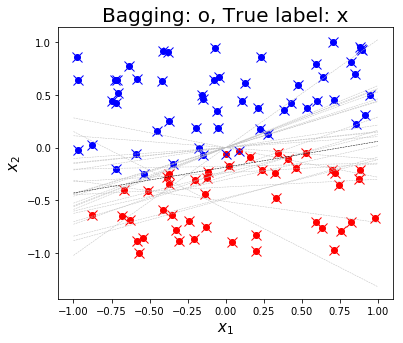

In [13]:
fig, ax = plt.subplots(1, 1,figsize=(6,5))
cols = {1: 'r', -1: 'b'}
l = np.linspace(-1,1)

for i in xrange(n_training_samples):
    plt.plot(Xbag[i][0][1], Xbag[i][0][2], cols[Xbag[i][1]]+'o')
    plt.plot(Xbag[i][0][1], Xbag[i][0][2], cols[pts[i][1]]+'x', markersize=10)

for i in xrange(n_bootstrap_samples):
    aa, bb = -w_blended[i][1]/w_blended[i][2], -w_blended[i][0]/w_blended[i][2]
    plt.plot(l, aa*l+bb,'--', color = '0.75', lw= 0.5)

cc, dd = -w_bag[1]/w_bag[2], -w_bag[0]/w_bag[2]
plt.plot(l, cc*l+dd,'k--', lw= 0.5)
plt.xlabel('$x_1$', multialignment='left', fontweight='bold', fontsize=15)
plt.ylabel('$x_2$', multialignment='left', fontweight='bold', fontsize=15)
plt.title('Bagging: o, True label: x', multialignment='left', fontsize=20)
plt.show()

### Exercise: ###  
<ul>
<li> [Bagging: experiment] Try different ways to generate samples. This can be done by modifying the `generate_points()` function in the `perceptron` class. Next divide the samples into training and test sets. Does bagging actually help in making predictions on the test set? You may find the `check_error()` function useful.
<li> [Bagging: experiment] Play with the size and number of bootstrap sets. Can you find a limit where bagging doesn't help at all in terms of out-of-sample performance?



<li>  [PLA: Theory] Let $\textbf{x}_n$ be the point that perceptron misclassified in the update round $t$ during which the weight used was $\textbf{w}_t$. This means that
$$
y_n\neq \text{sign }(\textbf{w}^T_t \tilde{\textbf{x}}_n),
$$
and the weight is updated according to
$$
 \textbf{w}_{t+1}\leftarrow \textbf{w}_{t}+ y_n\tilde{\textbf{x}}_n.
$$
Then which of the following is true? State your reasons.
  **1)**  $ \textbf{w}_{t+1}^T\tilde{\textbf{x}}_n=y_n$
  
  **2)**  $ \text{sign }(\textbf{w}_{t+1}^T\tilde{\textbf{x}}_n)=y_n$
  
  **3)**  $ y_n\textbf{w}_{t+1}^T\tilde{\textbf{x}}_n\ge y_n\textbf{w}_{t}^T\tilde{\textbf{x}}_n$
  
  **4)** $ y_n\textbf{w}_{t+1}^T\tilde{\textbf{x}}_n< y_n\textbf{w}_{t}^T\tilde{\textbf{x}}_n$

<li> [PLA: Theory] Show the following: let a sequence of examples $\mathcal{D}=\{(\textbf{x}_1,y_1),(\textbf{x}_2,y_2),\cdots,(\textbf{x}_N,y_N)\}$ be given. Suppose that there exists a perfect $\textbf{w}_f$ such that $y_n=\text{sign} (\textbf{w}_f^T \tilde{\textbf{x}}_n)$, $\forall n=1,\cdots, N$. Denote $R^2=\smash{\displaystyle\max_{n}}  \,||\tilde{\textbf{x}}_n||^2$ and $\rho=\smash{\displaystyle \min_{n}} \left(\,y_n \frac{\textbf{w}_f^T}{||\textbf{w}_f||} \tilde{\textbf{x}}_n\right)$. Then after $\tau$ mistake corrections through perceptron learning algorithm (PLA),
$$
\frac{\textbf{w}_f^T}{||\textbf{w}_f||}\frac{\textbf{w}_\tau}{||\textbf{w}_\tau||}\ge \sqrt{\tau} \left(\frac{\rho}{R}\right).
$$
Furthermore, the total number of mistakes that PLA makes on this sequence is at most $(R/\rho)^2$.

<li> [Theory: PLA] What's the physical meaning of $R$ and $\rho$ defined above? What does the bound you showed imply? Deduce from above that PLA actually aligns $\textbf{w}_t$ to the perfect $\textbf{w}_f$. In other words, *PLA actually learns how to classify*!!
</ul>
